### This scripts takes about 1 1/2 minutes seconds to execute

In [1]:
from tqdm.notebook import tqdm, trange
from importlib import reload
import horseracinglib
reload(horseracinglib)
from horseracinglib import *
import pandas as pd
from IPython.display import display, HTML
pd.options.display.max_columns = None

# Load test data (not seen by models) - Legacy MLR/trivial models

In [2]:
runners = pd.read_csv('data\\runners_test.csv', parse_dates=['meeting_date'], infer_datetime_format=True)
runners.sort_values(by=['race_id', 'runner_id'], inplace=True)

races = pd.read_csv('data\\races_test.csv', parse_dates=['meeting_date'], infer_datetime_format=True)
races.sort_values(by=['race_id'], inplace=True)

runners = runners.merge(races[["race_id", "course_Kempton", "course_Lingfield", "course_Southwell", "course_Wolverhampton", "class_1", "class_2", "class_3", "class_4", "class_5", "gt1mi"]], on='race_id', how='left')
runners.head()

,runner_id,race_id,meeting_date,stall_number,gender,age,trainer_id,trainer_sr,jockey_id,sire_id,sire_sr,dam_id,dam_sr,finpos,win,win_perc,win_perc_KEM,win_perc_LIN,win_perc_SOU,win_perc_WOL,sp,mkt_prob,overage,adj_mkt_prob,sr_30d,sr_lifetime_class_5,sr_lifetime_class_4,sr_lifetime_class_3,sr_lifetime_class_2,sr_lifetime_class_1,jockey_sr_KEM,jockey_sr_LIN,jockey_sr_SOU,jockey_sr_WOL,trainer_sr_KEM,trainer_sr_LIN,trainer_sr_SOU,trainer_sr_WOL,jockey_sr_30d,trainer_sr_30d,pos_prior1_KEM_le1mi,pos_prior2_KEM_le1mi,pos_prior3_KEM_le1mi,pos_prior1_LIN_le1mi,pos_prior2_LIN_le1mi,pos_prior3_LIN_le1mi,pos_prior1_SOU_le1mi,pos_prior2_SOU_le1mi,pos_prior3_SOU_le1mi,pos_prior1_WOL_le1mi,pos_prior2_WOL_le1mi,pos_prior3_WOL_le1mi,pos_prior1_KEM_gt1mi,pos_prior2_KEM_gt1mi,pos_prior3_KEM_gt1mi,pos_prior1_LIN_gt1mi,pos_prior2_LIN_gt1mi,pos_prior3_LIN_gt1mi,pos_prior1_SOU_gt1mi,pos_prior2_SOU_gt1mi,pos_prior3_SOU_gt1mi,pos_prior1_WOL_gt1mi,pos_prior2_WOL_gt1mi,pos_prior3_WOL_gt1mi,blinkers,visor,cheekpieces,tonguetie,entire,gelding,daysLTO,position1,position2,position3,position1_1,position1_2,position1_3,position1_4,position2_1,position2_2,position2_3,position2_4,position3_1,position3_2,position3_3,position3_4,course_Kempton,course_Lingfield,course_Southwell,course_Wolverhampton,class_1,class_2,class_3,class_4,class_5,gt1mi
0,595202,500816,2014-02-01,9,G,10,61455,0.030303,80094.0,11236,0.0,1370808,0.0,10,0,0.250,0.0,0.190476,0.0,0.0,17.0,0.058824,1.2206,0.048192,0.0,0.0,0.238095,0.312500,0.095238,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,4,1,0,4,4,2,0,0,0,0,0,0,2,2,1,0,4,3,0,0,0,4,2,0,0,0,0,0,0,1,14,4,4,2,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,605438,500816,2014-02-01,3,G,10,3414,0.116592,1147239.0,123415,0.0,107885,0.0,4,0,0.125,0.0,0.090909,0.0,0.0,17.0,0.058824,1.2206,0.048192,0.0,0.5,0.000000,0.210526,0.052632,0.111111,0.0,0.0000,0.0,1.0,0.0,0.0,1.0000,0.0,0.200000,0.176471,4,0,0,4,4,4,0,0,0,2,0,0,0,0,0,4,3,4,0,0,0,3,4,4,0,0,0,0,0,1,14,4,4,4,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
2,1482424,500816,2014-02-01,1,G,7,55425,0.102132,65282.0,220394,0.0,209539,0.0,8,0,0.250,0.0,0.100000,0.0,0.0,13.0,0.076923,1.2206,0.063021,0.0,0.1,0.166667,0.125000,0.200000,0.250000,0.0,0.0000,0.0,0.0,0.0,0.0,0.1667,0.0,0.111111,0.060606,4,2,4,4,4,4,1,0,0,4,0,0,1,4,0,4,4,1,0,0,0,0,1,1,0,0,1,0,0,1,14,4,4,4,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
3,1508677,500816,2014-02-01,4,G,6,16665,0.148867,31725.0,470430,0.0,468039,0.0,7,0,0.250,0.0,0.000000,0.0,0.0,7.0,0.142857,1.2206,0.117039,0.0,0.0,0.266667,0.000000,0.000000,0.000000,0.0,1.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.125926,0.153846,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,1,0,0,1,157,0,1,3,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,1610224,500816,2014-02-01,7,G,5,48032,0.134043,20113.0,655748,0.0,441052,0.0,3,0,0.400,0.0,0.000000,0.0,0.0,8.0,0.125000,1.2206,0.102409,1.0,0.5,1.000000,0.181818,0.000000,0.000000,0.0,0.6667,0.0,0.0,0.0,1.0,0.0000,0.0,0.109756,0.261905,4,1,0,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,29,1,4,4,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0


In [3]:
runners_single_race = runners[runners.race_id == 500816]
runners_single_race

,runner_id,race_id,meeting_date,stall_number,gender,age,trainer_id,trainer_sr,jockey_id,sire_id,sire_sr,dam_id,dam_sr,finpos,win,win_perc,win_perc_KEM,win_perc_LIN,win_perc_SOU,win_perc_WOL,sp,mkt_prob,overage,adj_mkt_prob,sr_30d,sr_lifetime_class_5,sr_lifetime_class_4,sr_lifetime_class_3,sr_lifetime_class_2,sr_lifetime_class_1,jockey_sr_KEM,jockey_sr_LIN,jockey_sr_SOU,jockey_sr_WOL,trainer_sr_KEM,trainer_sr_LIN,trainer_sr_SOU,trainer_sr_WOL,jockey_sr_30d,trainer_sr_30d,pos_prior1_KEM_le1mi,pos_prior2_KEM_le1mi,pos_prior3_KEM_le1mi,pos_prior1_LIN_le1mi,pos_prior2_LIN_le1mi,pos_prior3_LIN_le1mi,pos_prior1_SOU_le1mi,pos_prior2_SOU_le1mi,pos_prior3_SOU_le1mi,pos_prior1_WOL_le1mi,pos_prior2_WOL_le1mi,pos_prior3_WOL_le1mi,pos_prior1_KEM_gt1mi,pos_prior2_KEM_gt1mi,pos_prior3_KEM_gt1mi,pos_prior1_LIN_gt1mi,pos_prior2_LIN_gt1mi,pos_prior3_LIN_gt1mi,pos_prior1_SOU_gt1mi,pos_prior2_SOU_gt1mi,pos_prior3_SOU_gt1mi,pos_prior1_WOL_gt1mi,pos_prior2_WOL_gt1mi,pos_prior3_WOL_gt1mi,blinkers,visor,cheekpieces,tonguetie,entire,gelding,daysLTO,position1,position2,position3,position1_1,position1_2,position1_3,position1_4,position2_1,position2_2,position2_3,position2_4,position3_1,position3_2,position3_3,position3_4,course_Kempton,course_Lingfield,course_Southwell,course_Wolverhampton,class_1,class_2,class_3,class_4,class_5,gt1mi
0,595202,500816,2014-02-01,9,G,10,61455,0.030303,80094.0,11236,0.0,1370808,0.0,10,0,0.250000,0.0,0.190476,0.0,0.0,17.0,0.058824,1.2206,0.048192,0.0,0.000000,0.238095,0.312500,0.095238,0.000000,0.0,0.0000,0.00,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,4,1,0,4,4,2,0,0,0,0,0,0,2,2,1,0,4,3,0,0,0,4,2,0,0,0,0,0,0,1,14,4,4,2,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,605438,500816,2014-02-01,3,G,10,3414,0.116592,1147239.0,123415,0.0,107885,0.0,4,0,0.125000,0.0,0.090909,0.0,0.0,17.0,0.058824,1.2206,0.048192,0.0,0.500000,0.000000,0.210526,0.052632,0.111111,0.0,0.0000,0.00,1.0,0.0,0.0,1.0000,0.0,0.200000,0.176471,4,0,0,4,4,4,0,0,0,2,0,0,0,0,0,4,3,4,0,0,0,3,4,4,0,0,0,0,0,1,14,4,4,4,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
2,1482424,500816,2014-02-01,1,G,7,55425,0.102132,65282.0,220394,0.0,209539,0.0,8,0,0.250000,0.0,0.100000,0.0,0.0,13.0,0.076923,1.2206,0.063021,0.0,0.100000,0.166667,0.125000,0.200000,0.250000,0.0,0.0000,0.00,0.0,0.0,0.0,0.1667,0.0,0.111111,0.060606,4,2,4,4,4,4,1,0,0,4,0,0,1,4,0,4,4,1,0,0,0,0,1,1,0,0,1,0,0,1,14,4,4,4,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
3,1508677,500816,2014-02-01,4,G,6,16665,0.148867,31725.0,470430,0.0,468039,0.0,7,0,0.250000,0.0,0.000000,0.0,0.0,7.0,0.142857,1.2206,0.117039,0.0,0.000000,0.266667,0.000000,0.000000,0.000000,0.0,1.0000,0.00,0.0,0.0,0.0,0.0000,0.0,0.125926,0.153846,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,1,0,0,1,157,0,1,3,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,1610224,500816,2014-02-01,7,G,5,48032,0.134043,20113.0,655748,0.0,441052,0.0,3,0,0.400000,0.0,0.000000,0.0,0.0,8.0,0.125000,1.2206,0.102409,1.0,0.500000,1.000000,0.181818,0.000000,0.000000,0.0,0.6667,0.00,0.0,0.0,1.0,0.0000,0.0,0.109756,0.261905,4,1,0,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,29,1,4,4,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
5,1630469,500816,2014-02-01,6,G,5,2642,0.080537,75.0,421803,0.0,413075,0.0,6,0,0.111111,0.0,0.000000,0.0,0.0,17.0,0.058824,1.2206,0.048192,0.0,0.666667,0.142857,0.090909,0.083333,0.000000,0.0,1.0000,1.00,0.0,0.0,0.0,0.0000,0.0,0.200000,0.047059,3,4,4,3,4,4,0,0,0,3,3,4,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,1,8,3,4,4,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
6,1634456,500816,2014-02-01,8,G,5,48169,0.177083,18614.0,580505,0.0,462602,0.0,1,1,0.666667,0.0,1.000000,0.0,0.0,4.0,0.250000,1.2206,0.204818,0.5,0.500000,0.333333,0.250000,0.000000,0.000000,0.0,0.0000,0.00,0.0,1.0,0.0,0.0000,0.0,0.161290,0.100000,0,0,0,1,4,1,3,0,0,0,0,0,0,4,3,0,4,4,0,0,0,0,0,0,0,0,0,0,0,1,7,1,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
7,1737812,500816,2014-02-01,11,H,5,10977,0.117241,79905.0,202384,0.0,67182,0.0,2,0,0.000000,0.0,0.000000,0.0,0.0,9.0,0.111111,1.2206,0.091030,0

# Load test data (not seen by models) - New NN models

In [4]:
# note, test data is model-specific

test_data = torch.load('data\\mktprob_test_data.pt')
test_data.runners_wide.head()

C:\Users\gille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


mkt_prob                                                    \
stall_number        1         2         3         4         5         6    
race_id                                                                    
500812       -0.419505  1.321967 -0.612674 -0.897558  4.251480 -0.663923   
500813       -0.018508 -0.978520 -0.897558 -0.018508  1.163101 -0.419505   
500814        1.719145 -0.419505  0.607048  1.024086 -0.978520 -0.978520   
500815       -0.302851 -0.134352  0.130433  2.275198 -0.570469 -0.134352   
500816       -0.419505 -0.570469 -0.570469  0.130433  1.024086 -0.570469   

                                                                               \
stall_number        7         8         9         10        11   12   13   14   
race_id                                                                         
500812        0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
500813        0.455397 -0.018508 -0.612674 -0.740304  0.329026  0.0  0.0  0.0   
500814       -0.815785 -0.936612 -0.612674  1.024086  0.000000  0.0  0.0  0.0   
500815       -0.302851 -0.815785  0.130433 -0.612674  0.000000  0.0  0.0  0.0   
500816       -0.018508  1.024086 -0.570469 -0.815785 -0.134352  0.0  0.0  0.0   

                        win                                                    \
stall_number   15   16   1    2    3    4    5    6    7    8    9    10   11   
race_id                                                                         
500812        0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
500813        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
500814        0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
500815        0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
500816        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

                                       
stall_number   12   13   14   15   16  
race_id                                
500812        0.0  0.0  0.0  0.0  0.0  
500813        0.0  0.0  0.0  0.0  0.0  
500814        0.0  0.0  0.0  0.0  0.0  
500815        0.0  0.0  0.0  0.0  0.0  
500816        0.0  0.0  0.0  0.0  0.0

In [5]:
test_data.races.head()

""
race_id
500812
500813
500814
500815
500816


In [6]:
test_data.runners_wide.loc[runners_single_race.race_id.iloc[0], :]

          stall_number
mkt_prob  1              -0.419505
          2              -0.570469
          3              -0.570469
          4               0.130433
          5               1.024086
          6              -0.570469
          7              -0.018508
          8               1.024086
          9              -0.570469
          10             -0.815785
          11             -0.134352
          12              0.000000
          13              0.000000
          14              0.000000
          15              0.000000
          16              0.000000
win       1               0.000000
          2               0.000000
          3               0.000000
          4               0.000000
          5               0.000000
          6               0.000000
          7               0.000000
          8               1.000000
          9               0.000000
          10              0.000000
          11              0.000000
          12              0.0000

In [7]:
test_data.races.loc[runners_single_race.race_id.iloc[0], :]

Series([], Name: 500816, dtype: float64)

# Demonstrate calculating model probabilities for single race - Legacy MLR/trivial models

In [8]:
AlunOwen_multinomial_logit = MultinomialLogitModel('models\\AlunOwen_multinomial_logit_coefficients.csv', model_prefix='AO')
display(AlunOwen_multinomial_logit.model_coefficients)
AlunOwen_multinomial_logit.calculate_model_probabilities_for_single_race(runners_single_race)

,feature,coefficient
0,age,-0.071238
1,trainer_sr,3.082671
2,daysLTO,-0.000082
3,position1_1,0.416375
4,position1_2,0.301397
5,position1_3,0.196805
6,position1_4,-0.157751
7,position2_1,0.084662
8,position2_2,0.119383
9,position2_3,0.023896


,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.042552
1,500816,605438,3,0,0.047658
2,500816,1482424,1,0,0.042298
3,500816,1508677,4,0,0.074309
4,500816,1610224,7,0,0.127350
5,500816,1630469,6,0,0.086848
6,500816,1634456,8,1,0.173129
7,500816,1737812,11,0,0.112975
8,500816,1749809,5,0,0.149507
9,500816,1784112,10,0,0.065279


In [9]:
MG1_multinomial_logit = MultinomialLogitModel('models\\MG1_multinomial_logit_coefficients.csv', model_prefix='MG1')
display(MG1_multinomial_logit.model_coefficients)
MG1_multinomial_logit.calculate_model_probabilities_for_single_race(runners_single_race)

,feature,coefficient
0,sr_30d,0.571745
1,sr_lifetime_class_5,0.529637
2,sr_lifetime_class_4,0.333274
3,sr_lifetime_class_3,0.480274
4,sr_lifetime_class_2,0.811747
5,sr_lifetime_class_1,1.289735
6,jockey_sr_30d,1.345724
7,trainer_sr_30d,1.144841
8,position1_1,0.165849
9,position1_2,0.336574


,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.043268
1,500816,605438,3,0,0.088571
2,500816,1482424,1,0,0.076165
3,500816,1508677,4,0,0.056887
4,500816,1610224,7,0,0.239164
5,500816,1630469,6,0,0.106866
6,500816,1634456,8,1,0.132401
7,500816,1737812,11,0,0.061905
8,500816,1749809,5,0,0.084635
9,500816,1784112,10,0,0.058154


In [10]:
my_random_choice = RandomChoiceModel(model_prefix='RC')
my_random_choice.calculate_model_probabilities_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.038570
1,500816,605438,3,0,0.084809
2,500816,1482424,1,0,0.117262
3,500816,1508677,4,0,0.123598
4,500816,1610224,7,0,0.073172
5,500816,1630469,6,0,0.061406
6,500816,1634456,8,1,0.124525
7,500816,1737812,11,0,0.025154
8,500816,1749809,5,0,0.142938
9,500816,1784112,10,0,0.063591


In [11]:
my_favourite_choice = FavouriteChoiceModel(model_prefix='FC')
my_favourite_choice.calculate_model_probabilities_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.048192
1,500816,605438,3,0,0.048192
2,500816,1482424,1,0,0.063021
3,500816,1508677,4,0,0.117039
4,500816,1610224,7,0,0.102409
5,500816,1630469,6,0,0.048192
6,500816,1634456,8,1,0.204818
7,500816,1737812,11,0,0.091030
8,500816,1749809,5,0,0.204818
9,500816,1784112,10,0,0.024096


# Demonstrate calculating model probabilities for single race - New NN models

In [12]:
model_inventory = {}
for model_prefix, model_filename, test_data_filename in [('MP', 'models\\mktprob.pt', 'data\\mktprob_test_data.pt'), ('AO3', 'models\\AlunOwen_v3.pt', 'data\\AlunOwen_v3_test_data.pt')]:
    test_data = torch.load(test_data_filename)
    model_inventory[model_prefix] = NeuralNetworkModel(model_filename, test_data, model_prefix)
    display(model_inventory[model_prefix].model_object)
    display(model_inventory[model_prefix].calculate_model_probabilities_for_single_race(runners_single_race))

C:\Users\gille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


LinSig(
  (neural_network): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Sigmoid()
  )
)

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.020327
1,500816,605438,3,0,0.023181
2,500816,1482424,1,0,0.102902
3,500816,1508677,4,0,0.942360
4,500816,1610224,7,0,0.787433
5,500816,1630469,6,0,0.099752
6,500816,1634456,8,1,0.999941
7,500816,1737812,11,0,0.248312
8,500816,1749809,5,0,0.999968
9,500816,1784112,10,0,0.009439


C:\Users\gille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MLR(
  (neural_network): Sequential(
    (0): ParsLin()
    (1): Softmax(dim=1)
  )
)

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.000102
1,500816,605438,3,0,0.001593
2,500816,1482424,1,0,0.001447
3,500816,1508677,4,0,0.053931
4,500816,1610224,7,0,0.363638
5,500816,1630469,6,0,0.024976
6,500816,1634456,8,1,0.221734
7,500816,1737812,11,0,0.003929
8,500816,1749809,5,0,0.319800
9,500816,1784112,10,0,0.001304


# Demonstrate calculating model probabilities for multiple races

In [13]:
AlunOwen_multinomial_logit.calculate_model_probabilities_for_multiple_races(runners)
AlunOwen_multinomial_logit.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.042552
1,500816,605438,3,0,0.047658
2,500816,1482424,1,0,0.042298
3,500816,1508677,4,0,0.074309
4,500816,1610224,7,0,0.127350


In [14]:
MG1_multinomial_logit.calculate_model_probabilities_for_multiple_races(runners)
MG1_multinomial_logit.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.043268
1,500816,605438,3,0,0.088571
2,500816,1482424,1,0,0.076165
3,500816,1508677,4,0,0.056887
4,500816,1610224,7,0,0.239164


In [15]:
my_random_choice.calculate_model_probabilities_for_multiple_races(runners)
my_random_choice.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.111565
1,500816,605438,3,0,0.095922
2,500816,1482424,1,0,0.084482
3,500816,1508677,4,0,0.031059
4,500816,1610224,7,0,0.144762


In [16]:
my_favourite_choice.calculate_model_probabilities_for_multiple_races(runners)
my_favourite_choice.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.048192
1,500816,605438,3,0,0.048192
2,500816,1482424,1,0,0.063021
3,500816,1508677,4,0,0.117039
4,500816,1610224,7,0,0.102409


In [17]:
model_inventory['MP'].calculate_model_probabilities_for_multiple_races(runners)
model_inventory['MP'].model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.020327
1,500816,605438,3,0,0.023181
2,500816,1482424,1,0,0.102902
3,500816,1508677,4,0,0.942360
4,500816,1610224,7,0,0.787433


In [18]:
model_inventory['AO3'].calculate_model_probabilities_for_multiple_races(runners)
model_inventory['AO3'].model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500816,595202,9,0,0.000102
1,500816,605438,3,0,0.001593
2,500816,1482424,1,0,0.001447
3,500816,1508677,4,0,0.053931
4,500816,1610224,7,0,0.363638


# Calculate model accuracy

In [19]:
# All of the following code was written by ChatGPT-4

# Create an empty DataFrame
df = pd.DataFrame(columns=['Model', 'Accuracy'])

for model, model_prefix in [(AlunOwen_multinomial_logit, 'AO'), 
                            (MG1_multinomial_logit, 'MG1'),
                            (my_random_choice, 'RC'), 
                            (my_favourite_choice, 'FC')]:
    accuracy = model.calculate_model_accuracy(runners)
    df = pd.concat([df, pd.DataFrame([{'Model': model_prefix, 'Accuracy': f'{accuracy * 100:.1f}%'}])], ignore_index=True)

# Display the DataFrame as an HTML table
display(HTML(df.to_html(index=False)))

Model,Accuracy
AO,24.6%
MG1,21.6%
RC,12.1%
FC,34.8%


# Demonstrate probability model assessment

In [20]:
my_model_assessment = ProbabilityModelAssessment([AlunOwen_multinomial_logit, MG1_multinomial_logit, model_inventory['MP']], runners[['race_id', 'runner_id', 'stall_number', 'win', 'adj_mkt_prob']])
display(my_model_assessment.assessment)
my_model_assessment.perform_assessment()

,race_id,runner_id,stall_number,win,adj_mkt_prob,AO_mod_prob,MG1_mod_prob,MP_mod_prob
0,500816,595202,9,0,0.048192,0.042552,0.043268,0.020327
1,500816,605438,3,0,0.048192,0.047658,0.088571,0.023181
2,500816,1482424,1,0,0.063021,0.042298,0.076165,0.102902
3,500816,1508677,4,0,0.117039,0.074309,0.056887,0.942360
4,500816,1610224,7,0,0.102409,0.127350,0.239164,0.787433
...,...,...,...,...,...,...,...,...
12650,618885,2033964,4,0,0.033318,0.063403,0.065300,0.015114
12651,618885,2063077,9,0,0.058947,0.126962,0.070902,0.266067
12652,618885,2066887,7,0,0.045077,0.098350,0.100961,0.129243
12653,618885,2067790,12,0,0.022539,0.138594,0.107684,0.018622


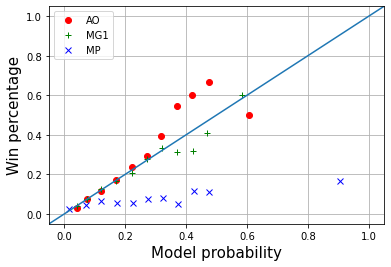

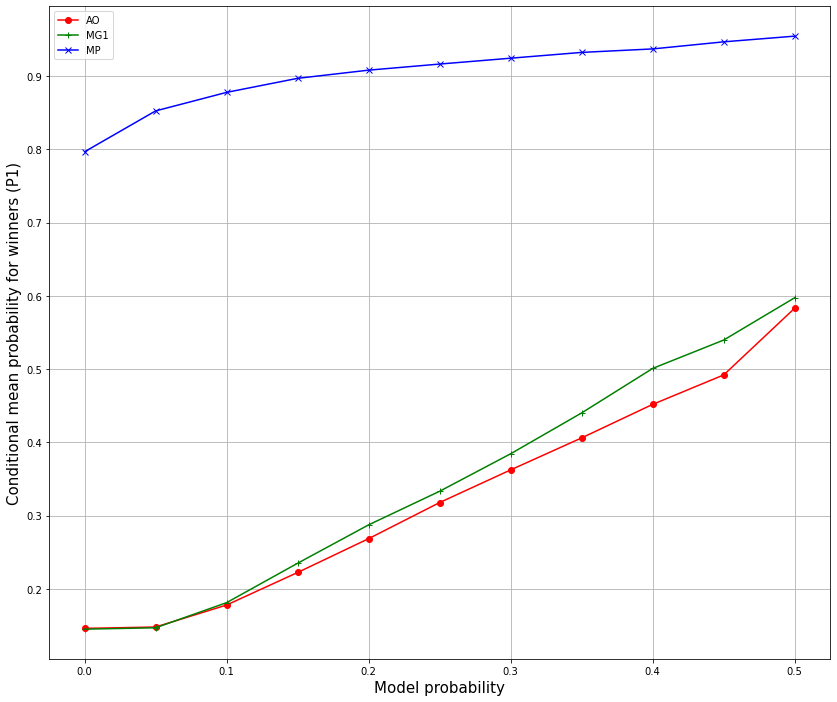

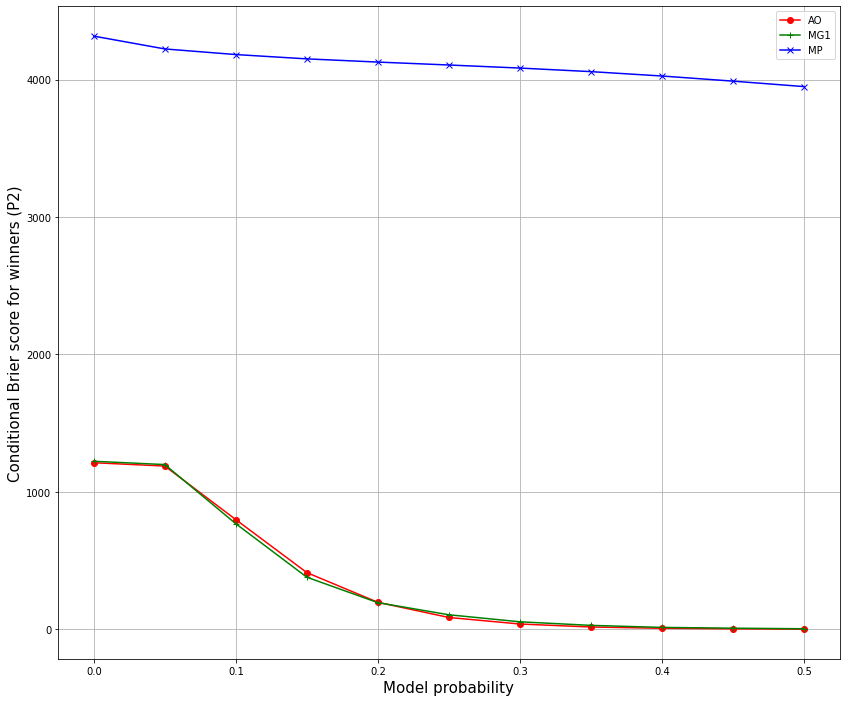

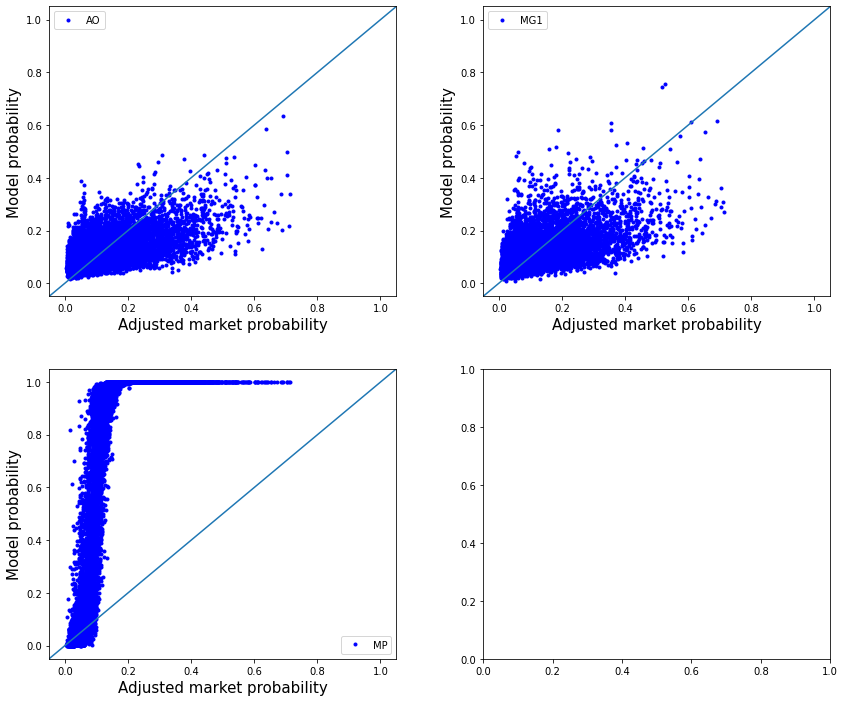

In [21]:
my_model_assessment.show_diagnostic_plots()

# Demonstrate calculating wagering strategy payoffs for single race

In [22]:
def pick_hi_mod_prob(augmented_runners_single_race):
    stakes = pd.Series(np.full(len(augmented_runners_single_race), 0, np.float64), index=augmented_runners_single_race.index)
    max_mod_prob = np.max(augmented_runners_single_race.mod_prob)
    i = augmented_runners_single_race[augmented_runners_single_race.mod_prob == max_mod_prob].index[0]
    stakes[i] = 1
    return stakes

def pick_cond(augmented_runners_single_race):
    return 1 * ((augmented_runners_single_race.mod_prob > 0.15) & (augmented_runners_single_race.mod_prob / augmented_runners_single_race.adj_mkt_prob > 0.13))

In [23]:
my_1st_strategy = WageringStrategy(AlunOwen_multinomial_logit, pick_hi_mod_prob, 'PickHiModProb')
my_1st_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500816,595202,9,17.0,0,0.042552,0.0,0.0
1,500816,605438,3,17.0,0,0.047658,0.0,0.0
2,500816,1482424,1,13.0,0,0.042298,0.0,0.0
3,500816,1508677,4,7.0,0,0.074309,0.0,0.0
4,500816,1610224,7,8.0,0,0.127350,0.0,0.0
5,500816,1630469,6,17.0,0,0.086848,0.0,0.0
6,500816,1634456,8,4.0,1,0.173129,1.0,4.0
7,500816,1737812,11,9.0,0,0.112975,0.0,0.0
8,500816,1749809,5,4.0,0,0.149507,0.0,0.0
9,500816,1784112,10,34.0,0,0.065279,0.0,0.0


In [24]:
my_2nd_strategy = WageringStrategy(my_favourite_choice, pick_hi_mod_prob, 'PickHiModProb')
my_2nd_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500816,595202,9,17.0,0,0.048192,0.0,0.0
1,500816,605438,3,17.0,0,0.048192,0.0,0.0
2,500816,1482424,1,13.0,0,0.063021,0.0,0.0
3,500816,1508677,4,7.0,0,0.117039,0.0,0.0
4,500816,1610224,7,8.0,0,0.102409,0.0,0.0
5,500816,1630469,6,17.0,0,0.048192,0.0,0.0
6,500816,1634456,8,4.0,1,0.204818,1.0,4.0
7,500816,1737812,11,9.0,0,0.091030,0.0,0.0
8,500816,1749809,5,4.0,0,0.204818,0.0,0.0
9,500816,1784112,10,34.0,0,0.024096,0.0,0.0


In [25]:
my_3rd_strategy = WageringStrategy(MG1_multinomial_logit, pick_hi_mod_prob, 'PickHiModProb')
my_3rd_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500816,595202,9,17.0,0,0.043268,0.0,0.0
1,500816,605438,3,17.0,0,0.088571,0.0,0.0
2,500816,1482424,1,13.0,0,0.076165,0.0,0.0
3,500816,1508677,4,7.0,0,0.056887,0.0,0.0
4,500816,1610224,7,8.0,0,0.239164,1.0,0.0
5,500816,1630469,6,17.0,0,0.106866,0.0,0.0
6,500816,1634456,8,4.0,1,0.132401,0.0,0.0
7,500816,1737812,11,9.0,0,0.061905,0.0,0.0
8,500816,1749809,5,4.0,0,0.084635,0.0,0.0
9,500816,1784112,10,34.0,0,0.058154,0.0,0.0


In [26]:
my_4th_strategy = WageringStrategy(my_random_choice, pick_hi_mod_prob, 'PickHiModProb')
my_4th_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500816,595202,9,17.0,0,0.096421,0.0,0.0
1,500816,605438,3,17.0,0,0.209473,0.0,0.0
2,500816,1482424,1,13.0,0,0.071351,0.0,0.0
3,500816,1508677,4,7.0,0,0.011813,0.0,0.0
4,500816,1610224,7,8.0,0,0.004573,0.0,0.0
5,500816,1630469,6,17.0,0,0.210396,1.0,0.0
6,500816,1634456,8,4.0,1,0.079615,0.0,0.0
7,500816,1737812,11,9.0,0,0.005950,0.0,0.0
8,500816,1749809,5,4.0,0,0.108717,0.0,0.0
9,500816,1784112,10,34.0,0,0.134184,0.0,0.0


# Demonstrate calculating wagering strategy payoffs for multiple races

In [27]:
my_1st_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_1st_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500816,595202,9,17.0,0,0.042552,0.0,0.0
1,500816,605438,3,17.0,0,0.047658,0.0,0.0
2,500816,1482424,1,13.0,0,0.042298,0.0,0.0
3,500816,1508677,4,7.0,0,0.074309,0.0,0.0
4,500816,1610224,7,8.0,0,0.127350,0.0,0.0


In [28]:
my_2nd_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_2nd_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500816,595202,9,17.0,0,0.048192,0.0,0.0
1,500816,605438,3,17.0,0,0.048192,0.0,0.0
2,500816,1482424,1,13.0,0,0.063021,0.0,0.0
3,500816,1508677,4,7.0,0,0.117039,0.0,0.0
4,500816,1610224,7,8.0,0,0.102409,0.0,0.0


In [29]:
my_3rd_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_3rd_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500816,595202,9,17.0,0,0.043268,0.0,0.0
1,500816,605438,3,17.0,0,0.088571,0.0,0.0
2,500816,1482424,1,13.0,0,0.076165,0.0,0.0
3,500816,1508677,4,7.0,0,0.056887,0.0,0.0
4,500816,1610224,7,8.0,0,0.239164,1.0,0.0


In [30]:
my_4th_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_4th_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500816,595202,9,17.0,0,0.063878,0.0,0.0
1,500816,605438,3,17.0,0,0.013118,0.0,0.0
2,500816,1482424,1,13.0,0,0.127527,0.0,0.0
3,500816,1508677,4,7.0,0,0.085276,0.0,0.0
4,500816,1610224,7,8.0,0,0.073553,0.0,0.0


# Demonstrate wagering strategy assessment

In [31]:
my_strategy_assessment = WageringStrategyAssessment([my_1st_strategy, my_2nd_strategy, my_3rd_strategy, my_4th_strategy], runners[['race_id', 'meeting_date', 'runner_id', 'stall_number', 'win', 'adj_mkt_prob']])
display(my_strategy_assessment.assessment)
my_strategy_assessment.perform_assessment()

,race_id,meeting_date,runner_id,stall_number,win,adj_mkt_prob,PickHiModProb(AO)_mod_prob,PickHiModProb(AO)_strat_stake,PickHiModProb(AO)_strat_payoff,PickHiModProb(FC)_mod_prob,PickHiModProb(FC)_strat_stake,PickHiModProb(FC)_strat_payoff,PickHiModProb(MG1)_mod_prob,PickHiModProb(MG1)_strat_stake,PickHiModProb(MG1)_strat_payoff,PickHiModProb(RC)_mod_prob,PickHiModProb(RC)_strat_stake,PickHiModProb(RC)_strat_payoff
0,500816,2014-02-01,595202,9,0,0.048192,0.042552,0.0,0.0,0.048192,0.0,0.0,0.043268,0.0,0.0,0.063878,0.0,0.0
1,500816,2014-02-01,605438,3,0,0.048192,0.047658,0.0,0.0,0.048192,0.0,0.0,0.088571,0.0,0.0,0.013118,0.0,0.0
2,500816,2014-02-01,1482424,1,0,0.063021,0.042298,0.0,0.0,0.063021,0.0,0.0,0.076165,0.0,0.0,0.127527,0.0,0.0
3,500816,2014-02-01,1508677,4,0,0.117039,0.074309,0.0,0.0,0.117039,0.0,0.0,0.056887,0.0,0.0,0.085276,0.0,0.0
4,500816,2014-02-01,1610224,7,0,0.102409,0.127350,0.0,0.0,0.102409,0.0,0.0,0.239164,1.0,0.0,0.073553,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12650,618885,2015-10-13,2033964,4,0,0.033318,0.063403,0.0,0.0,0.033318,0.0,0.0,0.065300,0.0,0.0,0.161954,1.0,0.0
12651,618885,2015-10-13,2063077,9,0,0.058947,0.126962,0.0,0.0,0.058947,0.0,0.0,0.070902,0.0,0.0,0.083218,0.0,0.0
12652,618885,2015-10-13,2066887,7,0,0.045077,0.098350,0.0,0.0,0.045077,0.0,0.0,0.100961,0.0,0.0,0.000278,0.0,0.0
12653,618885,2015-10-13,2067790,12,0,0.022539,0.138594,1.0,0.0,0.022539,0.0,0.0,0.107684,1.0,0.0,0.073905,0.0,0.0


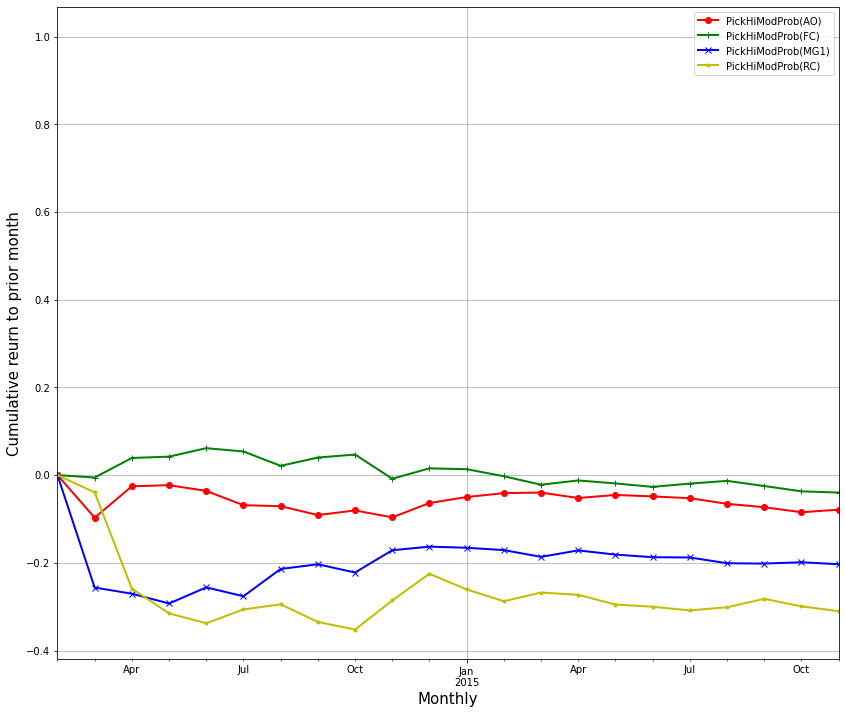

In [32]:
my_strategy_assessment.plot_cumulative_return()

In [34]:
my_strategy_assessment.monthly_assessment['PickHiModProb(AO)']

,as_of,strat_stake,strat_payoff,strat_ret,strat_stake_cumsum,strat_payoff_cumsum,strat_cumret
0,2014-02-01,0.0,0.00,0.000000,0.0,0.00,0.000000
1,2014-03-01,111.0,100.23,-0.097027,111.0,100.23,-0.097027
2,2014-04-01,133.0,137.54,0.034135,244.0,237.77,-0.025533
3,2014-05-01,88.0,86.62,-0.015682,332.0,324.39,-0.022922
4,2014-06-01,34.0,28.41,-0.164412,366.0,352.80,-0.036066
5,2014-07-01,36.0,21.63,-0.399167,402.0,374.43,-0.068582
6,2014-08-01,33.0,29.75,-0.098485,435.0,404.18,-0.070851
7,2014-09-01,59.0,44.83,-0.240169,494.0,449.01,-0.091073
8,2014-10-01,66.0,65.88,-0.001818,560.0,514.89,-0.080554
9,2014-11-01,80.0,63.43,-0.207125,640.0,578.32,-0.096375


In [35]:
my_strategy_assessment.monthly_assessment['PickHiModProb(MG1)']

,as_of,strat_stake,strat_payoff,strat_ret,strat_stake_cumsum,strat_payoff_cumsum,strat_cumret
0,2014-02-01,0.0,0.00,0.000000,0.0,0.00,0.000000
1,2014-03-01,111.0,82.54,-0.256396,111.0,82.54,-0.256396
2,2014-04-01,133.0,95.48,-0.282105,244.0,178.02,-0.270410
3,2014-05-01,88.0,56.80,-0.354545,332.0,234.82,-0.292711
4,2014-06-01,34.0,37.49,0.102647,366.0,272.31,-0.255984
5,2014-07-01,36.0,18.63,-0.482500,402.0,290.94,-0.276269
6,2014-08-01,33.0,51.00,0.545455,435.0,341.94,-0.213931
7,2014-09-01,59.0,51.59,-0.125593,494.0,393.53,-0.203381
8,2014-10-01,66.0,42.10,-0.362121,560.0,435.63,-0.222089
9,2014-11-01,80.0,94.75,0.184375,640.0,530.38,-0.171281
